# Определение перспективного тарифа для телеком-компании

**Цели проекта:** 

1. Провести анализ использования двух тарифов клиентами оператора сотовой связи.
2. Проверить различия в средней выручке для клиентов, использующих разные тарифы, и клиентов из разных регионов. 

**Используемые данные:** 
Выборка клиентов (количество клиентов — 500), представленная в пяти csv-файлах. В файлах содержится информация о звонках, совершённых пользователями, отправленных сообщениях, израсходованном интернет-трафике, информация о пользователях и информация о тарифах оператора связи. Более подробно о содержании файлов, а также описание признаков, можно найти в описании проекта.

# Оглавление

1. [Изучение данных из файлов](#review)
    <br>1.1 [Импорт библиотек и чтение файлов](#importing)
    <br>1.2 [Общая информация о данных](#general_info)
    <br>1.3 [Вывод](#conc1)
2. [Предобработка данных](#preproccesing)
    <br>2.1 [Замена типов](#feature_preproc)
    <br>2.2 [Создание сводной таблицы](#pivot)
    <br>2.3 [Расчёт помесячной выручки с каждого пользователя](#revenue)
    <br>2.4 [Вывод](#conc2)
3. [Анализ данных](#analysis)
    <br>3.1 [Расчёт статистических характеристик](#stats)
    <br>3.2 [Построение гистограмм](#histograms)
    <br>3.3 [Вывод](#conc3)
4. [Проверка гипотез](#hypothesis_testing)
    <br>4.1 [Гипотеза о средней выручке с пользователей разных тарифов](#tariffs)
    <br>4.2 [Гипотеза о средней выручке с пользователей из разных регионов](#regions)
    <br>4.3 [Вывод](#conc4)
5. [Заключение](#conclusion)

<a id="review"></a>
## 1. Изучение данных из файлов

<a id="importing"></a>
### 1.1. Импорт библиотек и чтение файлов
Импортируем необходимые для работы библиотеки и считываем файлы с данными.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from math import ceil

In [2]:
calls = pd.read_csv("/datasets/calls.csv")
internet = pd.read_csv("/datasets/internet.csv")
messages = pd.read_csv("/datasets/messages.csv")
tariffs = pd.read_csv("/datasets/tariffs.csv")
users = pd.read_csv("/datasets/users.csv")

datasets = [calls, internet, messages, tariffs, users]

<a id="general_info"></a>
### 1.2. Общая информация о  данных
Проверим данные на наличие пропусков:

In [3]:
for ds in datasets:
    print(ds.isna().sum())
    print("\n------------------------------------------\n")

id           0
call_date    0
duration     0
user_id      0
dtype: int64

------------------------------------------

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

------------------------------------------

id              0
message_date    0
user_id         0
dtype: int64

------------------------------------------

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

------------------------------------------

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

------------------------------------------



Пропуски есть только в данных, описывающих пользователей, в столбце `churn_date`. Это вызвано тем, что тариф действовал на момент выгрузки данных, поэтому как-то обрабатывать пропущенные значения не нужно.

Получим общую информацию о наборах данных. 

In [4]:
for ds in datasets:
    print(ds.info())
    print("\n------------------------------------------\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

------------------------------------------

<c

Ничего странного здесь не видно. Можно посмотреть на статистическое описание некоторых признаков и количество уникальных значений.

In [5]:
calls["duration"].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

In [6]:
internet["mb_used"].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [7]:
users["age"].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [8]:
users["tariff"].unique()

array(['ultra', 'smart'], dtype=object)

Тут тоже ничего не бросается в глаза. 

<a id="conc1"></a>
### 1.3. Вывод
Обнаруженные в столбце `churn_date` пропуски объясняются его "физическим смыслом" и не требуют обработки. Явных ошибок в данных или некорректных значений в данных не обнаружено.

<a id="preproccesing"></a>
## 2. Предобработка данных

<a id="feature_preproc"></a>
### 2.1. Замена типов
Приведём столбцы с датами к типу `datetime`, запишем отдельным столбцом месяцы в таблицах `calls`, `internet`, `messages`, поскольку это потребуется для дальнейшего анализа.

In [9]:
calls["call_date"] = pd.to_datetime(calls["call_date"], format="%Y-%m-%d")
internet["session_date"] = pd.to_datetime(internet["session_date"], format="%Y-%m-%d")
messages["message_date"] = pd.to_datetime(messages["message_date"], format="%Y-%m-%d")
users["reg_date"] = pd.to_datetime(users["reg_date"], format="%Y-%m-%d")

In [10]:
calls["call_month"] = pd.DatetimeIndex(calls["call_date"]).month
internet["session_month"] = pd.DatetimeIndex(internet["session_date"]).month
messages["message_month"] = pd.DatetimeIndex(messages["message_date"]).month

Округлим вверх продолжительность каждого звонка в минутах и запишем эти значения в `duration_ceiled`. Затем создадим сводную таблицу, в которой индексами будут id пользователя и месяцы, в столбцах будут записаны общая продолжительность звонков в минутах (за месяц) и их количество.

In [11]:
calls["duration_ceiled"] = calls["duration"].apply(np.ceil)

In [12]:
calls_pivot = calls.pivot_table(index=["user_id", "call_month"], 
                                values="duration_ceiled", 
                                aggfunc=["sum", "count"])

calls_pivot.columns = ["sum_duration", "count_duration"]

In [13]:
calls_pivot.head()

sum_duration  count_duration
user_id call_month                              
1000    5                  159.0              22
        6                  172.0              43
        7                  340.0              47
        8                  408.0              52
        9                  466.0              58

Для таблицы `internet` проведём почти аналогичную операцию, только округление будем производить уже после создания сводной таблицы (в соответствии с указанным в описании проекта примечанием).

In [14]:
internet_pivot = internet.pivot_table(index=["user_id", "session_month"], 
                                      values="mb_used", 
                                      aggfunc=["sum", "count"])

internet_pivot.columns = ["sum_mb_used", "sessions_count"]

internet_pivot["sum_mb_used_ceiled"] = internet_pivot["sum_mb_used"].apply(np.ceil)

In [15]:
internet_pivot.head()

sum_mb_used  sessions_count  sum_mb_used_ceiled
user_id session_month                                                 
1000    5                  2253.49               5              2254.0
        6                 23233.77              49             23234.0
        7                 14003.64              29             14004.0
        8                 14055.93              29             14056.0
        9                 14568.91              27             14569.0

Аналогично создадим сводную таблицу по сообщениям.

In [16]:
messages_pivot = messages.pivot_table(index=["user_id", "message_month"],
                                      values="id",
                                      aggfunc=["count"])

messages_pivot.columns = ["messages_count"]

In [17]:
messages_pivot.head()

messages_count
user_id message_month                
1000    5                          22
        6                          60
        7                          75
        8                          81
        9                          57

Оценим доли пропущенных звонков и сессий с нулевым трафиком.

In [18]:
print(f"Доля пропущенных звонков: {calls['duration'].value_counts(normalize=True)[0]:.1%}")
print(f"Доля сессий с нулевым трафиком: {internet['mb_used'].value_counts(normalize=True)[0]:.1%}")

Доля пропущенных звонков: 19.6%
Доля сессий с нулевым трафиком: 13.1%


Доли нулей достаточно большие, однако нет смысла эти нули как-то обрабатывать.

<a id="pivot"></a>
### 2.2. Создание сводной таблицы
Теперь объедим полученные таблицы в одну, которую назовём `data_pivot`. В новой таблице будут пропущенные значения. Они будут соответствовать тем пользователям, которые не отправляли сообщений, не производили звонков или не использовали интернет-трафик. Исходя из этого, пропуски можно просто заполнить нулями. 

Затем приведём данные в `sum_duration`, `count_duration`, `messages_count` к целым числам, а от столбца `sum_mb_used` избавимся, так как есть столбец с округлёнными значениями. 

После этого добавим в таблицу информацию о названии тарифа, который использует абонент.

In [19]:
users.index = users["user_id"]

In [20]:
data_pivot = internet_pivot.join(calls_pivot, on=["user_id", "session_month"], how="outer")
data_pivot = data_pivot.join(messages_pivot, on=["user_id", "session_month"], how="outer")
data_pivot
data_pivot.fillna(0, inplace=True)

data_pivot["sum_duration"] = data_pivot["sum_duration"].astype(int)
data_pivot["count_duration"] = data_pivot["count_duration"].astype(int)
data_pivot["messages_count"] = data_pivot["messages_count"].astype(int)

data_pivot.drop(columns="sum_mb_used", inplace=True)

data_pivot = data_pivot.join(users["tariff"], on="user_id")

In [21]:
data_pivot.head(20)

sessions_count  sum_mb_used_ceiled  sum_duration  \
user_id session_month                                                     
1000    5                         5.0              2254.0           159   
        6                        49.0             23234.0           172   
        7                        29.0             14004.0           340   
        8                        29.0             14056.0           408   
        9                        27.0             14569.0           466   
        10                       27.0             14703.0           350   
        11                       24.0             14757.0           338   
        12                       21.0              9818.0           333   
1001    11                       55.0             18430.0           430   
        12                       41.0             14037.0           414   
1002    6                        34.0             10857.0           117   
        7                        58.0             17581.0           214   
        8                        60.0             20320.0           289   
        9                        56.0             16692.0           206   
        10                       44.0             13889.0           212   
        11                       55.0             18588.0           243   
        12                       62.0             18114.0           236   
1003    8                        15.0              8566.0           380   
        9                        22.0             12469.0           961   
        10                       25.0             14769.0           855   

                       count_duration  messages_count tariff  
user_id session_month                                         
1000    5                          22              22  ultra  
        6                          43              60  ultra  
        7                          47              75  ultra  
        8                          52              81  ultra  
        9                          58              57  ultra  
        10                         57              73  ultra  
        11                         43              58  ultra  
        12                         46              70  ultra  
1001    11                         59               0  smart  
        12                         63               0  smart  
1002    6                          15               4  smart  
        7                          26              11  smart  
        8                          42              13  smart  
        9                          36               4  smart  
        10                         33              10  smart  
        11                         32              16  smart  
        12                         33              12  smart  
1003    8                          55              37  ultra  
        9                         134              91  ultra  
        10                        108              83  ultra

In [22]:
print("Проверка интернет-трафика:          ", data_pivot["sum_mb_used_ceiled"].sum() == internet_pivot["sum_mb_used_ceiled"].sum())
print("Проверка общей длительности звонков:", data_pivot["sum_duration"].sum() == calls_pivot["sum_duration"].sum())
print("Проверка количества звонков:        ", data_pivot["count_duration"].sum() == calls_pivot["count_duration"].sum())
print("Проверка количества сообщений:      ", data_pivot["messages_count"].sum() == messages_pivot["messages_count"].sum())

Проверка интернет-трафика:           True
Проверка общей длительности звонков: True
Проверка количества звонков:         True
Проверка количества сообщений:       True


Всё верно, перейдём к расчёту помесячной выручки с каждого пользователя.

<a id="revenue"></a>
### 2.3. Расчёт помесячной выручки с каждого пользователя
Посчитаем помесячную выручку с каждого пользователя. Расчёт будет производиться следующим образом:
 - считаем разность фактически потраченного количества минут/звонков/МБ трафика и бесплатного лимита по условиям тарифа;
 - если разность больше нуля, то умножаем её на значение из тарифа;
 - добавляем абоненскую плату.
 
Чтобы добавить столбец с этой величиной (`revenue_from_user`), напишем функцию `calculate_revenue_from_user`.

In [23]:
def calculate_revenue_from_user(data):
    tariff = data['tariff']
    
    selected_tariff = tariffs.query("tariff_name == @tariff")
    
    MESSAGES_INCLUDED = selected_tariff["messages_included"].values[0]
    MB_PER_MONTH_INCLUDED = selected_tariff["mb_per_month_included"].values[0]
    MINUTES_INCLUDED = selected_tariff["minutes_included"].values[0]
    RUB_MONTHLY_FEE = selected_tariff["rub_monthly_fee"].values[0]
    RUB_PER_GB = selected_tariff["rub_per_gb"].values[0]
    RUB_PER_MESSAGE = selected_tariff["rub_per_message"].values[0]
    RUB_PER_MINUTE = selected_tariff["rub_per_minute"].values[0]
    
    revenue = 0
    
    if data["messages_count"] - MESSAGES_INCLUDED > 0:
        revenue += (data["messages_count"] - MESSAGES_INCLUDED) * RUB_PER_MESSAGE
        
    if data["sum_duration"] - MINUTES_INCLUDED > 0:
        revenue += (data["sum_duration"] - MINUTES_INCLUDED) * RUB_PER_MINUTE
        
    if data["sum_mb_used_ceiled"] - MB_PER_MONTH_INCLUDED > 0:
        revenue += np.ceil((data["sum_mb_used_ceiled"] - MB_PER_MONTH_INCLUDED)/1024) * RUB_PER_GB

    revenue += RUB_MONTHLY_FEE
    
    return revenue

Применим функцию к таблице `data_pivot`, используя метод `.apply()`.

In [24]:
data_pivot["revenue_from_user"] = data_pivot.apply(calculate_revenue_from_user, axis=1)

In [25]:
data_pivot.head(15)

sessions_count  sum_mb_used_ceiled  sum_duration  \
user_id session_month                                                     
1000    5                         5.0              2254.0           159   
        6                        49.0             23234.0           172   
        7                        29.0             14004.0           340   
        8                        29.0             14056.0           408   
        9                        27.0             14569.0           466   
        10                       27.0             14703.0           350   
        11                       24.0             14757.0           338   
        12                       21.0              9818.0           333   
1001    11                       55.0             18430.0           430   
        12                       41.0             14037.0           414   
1002    6                        34.0             10857.0           117   
        7                        58.0             17581.0           214   
        8                        60.0             20320.0           289   
        9                        56.0             16692.0           206   
        10                       44.0             13889.0           212   

                       count_duration  messages_count tariff  \
user_id session_month                                          
1000    5                          22              22  ultra   
        6                          43              60  ultra   
        7                          47              75  ultra   
        8                          52              81  ultra   
        9                          58              57  ultra   
        10                         57              73  ultra   
        11                         43              58  ultra   
        12                         46              70  ultra   
1001    11                         59               0  smart   
        12                         63               0  smart   
1002    6                          15               4  smart   
        7                          26              11  smart   
        8                          42              13  smart   
        9                          36               4  smart   
        10                         33              10  smart   

                       revenue_from_user  
user_id session_month                     
1000    5                         1950.0  
        6                         1950.0  
        7                         1950.0  
        8                         1950.0  
        9                         1950.0  
        10                        1950.0  
        11                        1950.0  
        12                        1950.0  
1001    11                        1150.0  
        12                         550.0  
1002    6                          550.0  
        7                         1150.0  
        8                         1550.0  
        9                          950.0  
        10                         550.0

Построим гистограмму распределения для нового признака.

In [26]:
data_pivot

sessions_count  sum_mb_used_ceiled  sum_duration  \
user_id session_month                                                     
1000    5                         5.0              2254.0           159   
        6                        49.0             23234.0           172   
        7                        29.0             14004.0           340   
        8                        29.0             14056.0           408   
        9                        27.0             14569.0           466   
...                               ...                 ...           ...   
1273    11                        0.0                 0.0           272   
        12                        0.0                 0.0           260   
1377    2                         0.0                 0.0           179   
1392    2                         0.0                 0.0            13   
1446    8                         0.0                 0.0            50   

                       count_duration  messages_count tariff  \
user_id session_month                                          
1000    5                          22              22  ultra   
        6                          43              60  ultra   
        7                          47              75  ultra   
        8                          52              81  ultra   
        9                          58              57  ultra   
...                               ...             ...    ...   
1273    11                         45              29  ultra   
        12                         41              39  ultra   
1377    2                          23               2  ultra   
1392    2                           2               3  ultra   
1446    8                           4               1  smart   

                       revenue_from_user  
user_id session_month                     
1000    5                         1950.0  
        6                         1950.0  
        7                         1950.0  
        8                         1950.0  
        9                         1950.0  
...                                  ...  
1273    11                        1950.0  
        12                        1950.0  
1377    2                         1950.0  
1392    2                         1950.0  
1446    8                          550.0  

[3214 rows x 7 columns]

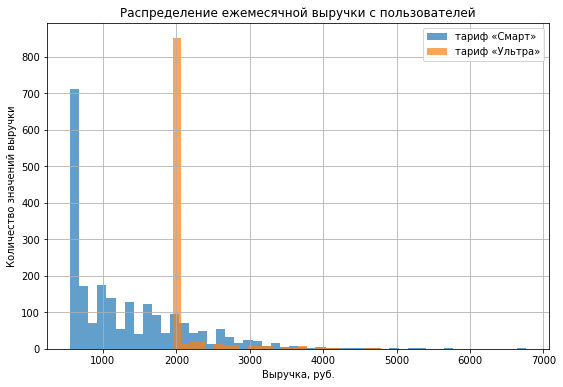

In [27]:
data_pivot.query("tariff == 'smart'")["revenue_from_user"].plot(kind="hist", bins=50, grid=True, figsize=(9, 6), alpha=0.7,
                                     title="Распределение ежемесячной выручки с пользователей")
data_pivot.query("tariff != 'smart'")["revenue_from_user"].plot(kind="hist", bins=25, grid=True, figsize=(9, 6), alpha=0.7,
                                     title="Распределение ежемесячной выручки с пользователей")

plt.xlabel("Выручка, руб.")
plt.ylabel("Количество значений выручки")
plt.legend(["тариф «Смарт»", "тариф «Ультра»"]);

In [28]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Можно заметить два пика: первый примерно соответствует 500 рублям, второй — 2000. Полученные значения совпадают с ежемесячными платежами для разных тарифов. Следовательно, значительное число пользователей тарифа «Ультра» укладывается в лимиты, обозначенные тарифным планом. Поскольку пользователи тарифа «Ультра» платят в месяц не менее 1950 рублей, то все значения левее относятся к пользователям «Смарт». Поэтому по гистограмме можно сделать вывод, что пользователи «Смарт» несколько чаще не укладываются в лимиты тарифа. 

In [29]:
smart_users = data_pivot.query("tariff == 'smart'")
ultra_users = data_pivot.query("tariff == 'ultra'")

In [30]:
print("Доля пользователей, которые не укладываются в лимиты тарифов")
print(f"\tтариф Смарт  {(smart_users['revenue_from_user'] > 550).mean():.1%}")
print(f"\tтариф Ультра {(ultra_users['revenue_from_user'] > 1950).mean():.1%}")

Доля пользователей, которые не укладываются в лимиты тарифов
	тариф Смарт  74.6%
	тариф Ультра 13.6%


In [31]:
print("Средний размер платы сверх стоимости тарифа")
print(f"\tтариф Смарт   {(smart_users.query('revenue_from_user > 550')['revenue_from_user'] - 550).mean():.2f} руб.")
print(f"\tтариф Ультра  {(ultra_users.query('revenue_from_user > 1950')['revenue_from_user'] - 1950).mean():.2f} руб.")

Средний размер платы сверх стоимости тарифа
	тариф Смарт   992.42 руб.
	тариф Ультра  883.21 руб.


<a id="conc2"></a>
### 2.4. Вывод
Произведена замена типа данных там, где это требовалось. Создана сводная таблица с данными, которые будут использоваться в дальнейшей работе. Рассчитана и внесена в сводную таблицу помесячная выручка с каждого пользователя.

<a id="analysis"></a>
## 3. Анализ данных

<a id="stats"></a>
### 3.1. Расчёт статистических характеристик
Выберем пользователей, которые пользуются тем или иным тарифом. Применим метод `.query()` к `data_pivot`, затем сделаем две сводных таблицы, в которых будем считать среднее, дисперсию и стандартное отклонение для количества израсходованного интернет-трафика, продолжительность звонков и количества отправленных сообщений для каждого пользователя. В `smart_users_stat` будут данные о пользователях тарифа «Смарт», в `ultra_users_stat` — о пользователях тарифа «Ультра».

In [32]:
smart_users = data_pivot.query("tariff == 'smart'")
ultra_users = data_pivot.query("tariff == 'ultra'")

In [33]:
smart_users_stat = smart_users.pivot_table(index="user_id", 
                                           values=["sum_mb_used_ceiled", "sum_duration", "messages_count"],
                                           aggfunc=["mean", "std", "var"])

ultra_users_stat = ultra_users.pivot_table(index="user_id", 
                                           values=["sum_mb_used_ceiled", "sum_duration", "messages_count"],
                                           aggfunc=["mean", "std", "var"])

In [34]:
smart_users_stat.head()

mean                                            std  \
        messages_count sum_duration sum_mb_used_ceiled messages_count   
user_id                                                                 
1001               0.0   422.000000       16233.500000       0.000000   
1002              10.0   216.714286       16577.285714       4.509250   
1005              46.0   550.416667        8307.666667      14.396969   
1006               0.0   318.272727       14926.727273       0.000000   
1007              25.0   486.555556       14625.666667       7.905694   

                                                   var                \
        sum_duration sum_mb_used_ceiled messages_count  sum_duration   
user_id                                                                
1001       11.313708        3106.320090       0.000000    128.000000   
1002       52.242110        3198.476810      20.333333   2729.238095   
1005      163.198963        2440.831018     207.272727  26633.901515   
1006      109.454183        5322.181566       0.000000  11980.218182   
1007      131.142204        3597.862629      62.500000  17198.277778   

                            
        sum_mb_used_ceiled  
user_id                     
1001          9.649224e+06  
1002          1.023025e+07  
1005          5.957656e+06  
1006          2.832562e+07  
1007          1.294462e+07

In [35]:
ultra_users_stat.head()

mean                                            std  \
        messages_count sum_duration sum_mb_used_ceiled messages_count   
user_id                                                                 
1000              62.0      320.750          13424.375      18.361450   
1003              76.0      764.400          11456.600      23.021729   
1004             149.0      123.375          18630.625      25.867796   
1013              21.0      468.000          15259.500       5.656854   
1016              71.0       61.000          13406.000      45.254834   

                                                   var                \
        sum_duration sum_mb_used_ceiled messages_count  sum_duration   
user_id                                                                
1000      106.014487        5848.904829     337.142857  11239.071429   
1003      223.377036        2352.848975     530.000000  49897.300000   
1004       39.626605        4815.063979     669.142857   1570.267857   
1013      140.007143        7747.769001      32.000000  19602.000000   
1016       46.669048        8517.808286    2048.000000   2178.000000   

                            
        sum_mb_used_ceiled  
user_id                     
1000          3.420969e+07  
1003          5.535898e+06  
1004          2.318484e+07  
1013          6.002792e+07  
1016          7.255306e+07

Статистические характеристики
* _для пользователей тарифа «Смарт»_:

In [36]:
smart_stats = {
    "mean": smart_users[["sum_mb_used_ceiled", "sum_duration", "messages_count"]].mean().round(1),
    "var": smart_users[["sum_mb_used_ceiled", "sum_duration", "messages_count"]].var().round(1),
    "std": smart_users[["sum_mb_used_ceiled", "sum_duration", "messages_count"]].std().round(1)
}

smart_stats = pd.DataFrame(smart_stats, 
                           columns=["mean", "var", "std"], 
                           index=["sum_mb_used_ceiled", "sum_duration", "messages_count"])
smart_stats

,mean,var,std
sum_mb_used_ceiled,16208.9,34462562.8,5870.5
sum_duration,417.9,36219.3,190.3
messages_count,33.4,796.8,28.2


* _для пользователей тарифа «Ультра»_:

In [37]:
ultra_stats = {
    "mean": ultra_users[["sum_mb_used_ceiled", "sum_duration", "messages_count"]].mean().round(1),
    "var": ultra_users[["sum_mb_used_ceiled", "sum_duration", "messages_count"]].var().round(1),
    "std": ultra_users[["sum_mb_used_ceiled", "sum_duration", "messages_count"]].std().round(1)
}

ultra_stats = pd.DataFrame(ultra_stats, 
                           columns=["mean", "var", "std"], 
                           index=["sum_mb_used_ceiled", "sum_duration", "messages_count"])
ultra_stats

,mean,var,std
sum_mb_used_ceiled,19469.3,101751558.0,10087.2
sum_duration,526.6,100873.6,317.6
messages_count,49.4,2285.3,47.8


Построим гистограммы распределений для этих признаков.
<a id="histograms"></a>
### 3.2. Построение гистограмм

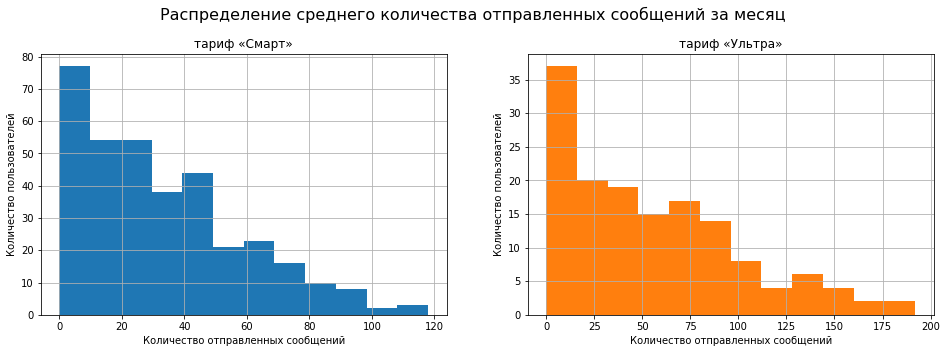

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

fig.suptitle("Распределение среднего количества отправленных сообщений за месяц", fontsize=16)

plt.subplot(1, 2, 1)
smart_users_stat["mean"]["messages_count"].plot(kind="hist", bins=12, grid=True, color="tab:blue")
plt.xlabel("Количество отправленных сообщений")
plt.ylabel("Количество пользователей")
plt.title("тариф «Смарт»")

plt.subplot(1, 2, 2)
ultra_users_stat["mean"]["messages_count"].plot(kind="hist", bins=12, grid=True, color="tab:orange")                                 
plt.xlabel("Количество отправленных сообщений")
plt.ylabel("Количество пользователей")
plt.title("тариф «Ультра»")

plt.subplots_adjust(top=0.85)
plt.show()

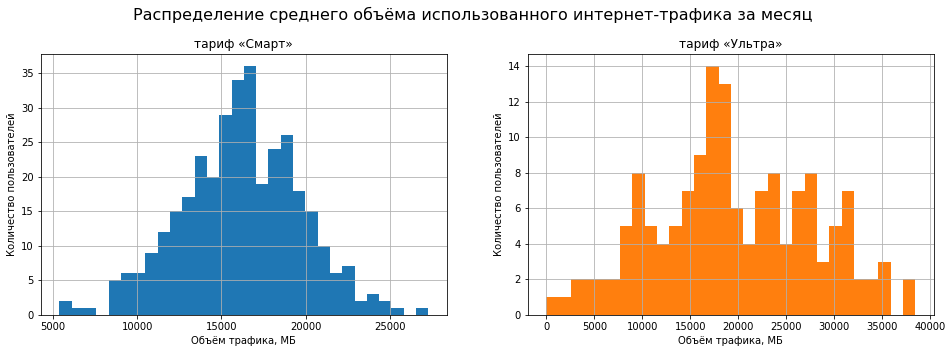

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

fig.suptitle("Распределение среднего объёма использованного интернет-трафика за месяц", fontsize=16)

plt.subplot(1, 2, 1)
smart_users_stat["mean"]["sum_mb_used_ceiled"].plot(kind="hist", bins=30, grid=True, color="tab:blue")
plt.xlabel("Объём трафика, МБ")
plt.ylabel("Количество пользователей")
plt.title("тариф «Смарт»")

plt.subplot(1, 2, 2)
ultra_users_stat["mean"]["sum_mb_used_ceiled"].plot(kind="hist", bins=30, grid=True, color="tab:orange")                               
plt.xlabel("Объём трафика, МБ")
plt.ylabel("Количество пользователей")
plt.title("тариф «Ультра»")

plt.subplots_adjust(top=0.85)
plt.show()

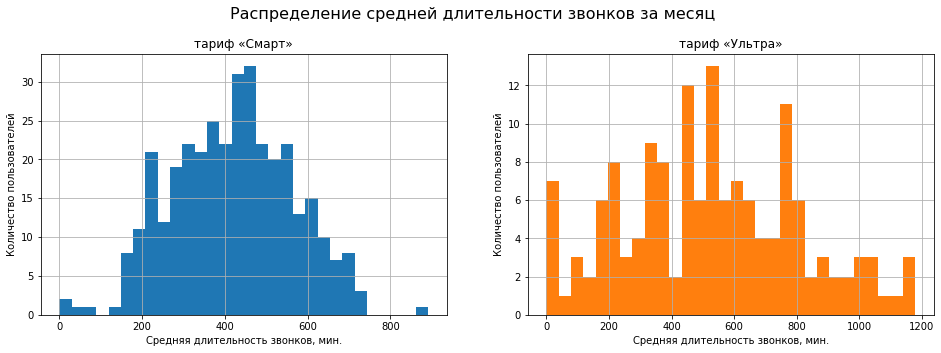

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

fig.suptitle("Распределение средней длительности звонков за месяц", fontsize=16)

plt.subplot(1, 2, 1)
smart_users_stat["mean"]["sum_duration"].plot(kind="hist", bins=30, grid=True, color="tab:blue")    
plt.xlabel("Средняя длительность звонков, мин.")
plt.ylabel("Количество пользователей")
plt.title("тариф «Смарт»")

plt.subplot(1, 2, 2)
ultra_users_stat["mean"]["sum_duration"].plot(kind="hist", bins=30, grid=True, color="tab:orange")                        
plt.xlabel("Средняя длительность звонков, мин.")
plt.ylabel("Количество пользователей")
plt.title("тариф «Ультра»")

plt.subplots_adjust(top=0.85)
plt.show()

Формы распределений попарно похожи, однако из-за того, что пользователей тарифа «Ультра» несколько меньше, чем пользователей «Смарт», гистограммы получаются менее гладкими. 

По форме распределения среднего количества отправленных сообщений напоминают пуассоновское. Распределения среднего объёма использованного интернет-трафика и средней длительности звонков похожи на нормальные, что подтверждает центральную предельную теорему. Можно заметить, что пользователи «Ультра» тратят несколько больше трафика в месяц, а средняя продолжительность звонков за месяц у них несколько выше, чем у пользователей «Смарт». Из гисторамм видно, что примерно половина пользователей тарифа «Смарт» превышает лимиты интернет-трафика и количества минут, а пользователи тарифа «Ультра», наоборот, почти всегда укладываются.

<a id="conc3"></a>
### 3.4. Вывод
Были рассчитаны статистические характеристики для двух выборок (пользователей двух тарифов). Построены гистограммы распределений среднего количества отправленных сообщений, объёма использованного интренет-трафика и длительности звонков за месяц, произведён анализ получившихся распределений.

<a id="hypothesis_testing"></a>
## 4. Проверка гипотез
<a id="tariffs"></a>
### 4.1. Гипотеза о средней выручке с пользователей разных тарифов
Необходимо проверить гипотезу, что _средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются_. Пойдём от обратного, будем проверять гипотезу, что _средняя выручка пользователей тарифов «Ультра» и «Смарт» **не** различаются_. 

Разделим всю выборку на две части: в первую попадут пользователи тарифа «Смарт», а во вторую — «Ультра». 

In [41]:
smart_users_renevue = smart_users["revenue_from_user"].values
ultra_users_renevue = ultra_users["revenue_from_user"].values

Будем проверять гипотезу $H_0$, альтернативной гипотезой будет $H_a$.

$H_0$: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы

$H_a$: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

$H_0$ — это гипотеза о равенстве среднего двух генеральных совокупностей. Будем считать, что дисперсии у выборок, по которым будем проверять гипотезу, равны. Уровень значимости ${\alpha}$ присвоим значение `0.05`.  

Для проверки гипотезы по выборкам используем функцию `ttest_ind`. 

In [42]:
alpha = 0.05
results = st.ttest_ind(ultra_users_renevue, smart_users_renevue)

if results.pvalue < alpha:
    print(f"p-value: {results.pvalue}")
    print("Отвергаем нулевую гипотезу")
else:
    print(f"p-value: {results.pvalue}")
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


In [43]:
print("Средняя выручка пользователей тарифа «Смарт»: ", smart_users_renevue.mean().round(2), "руб.")
print("Средняя выручка пользователей тарифа «Ультра»:", ultra_users_renevue.mean().round(2), "руб.")

Средняя выручка пользователей тарифа «Смарт»:  1289.97 руб.
Средняя выручка пользователей тарифа «Ультра»: 2070.15 руб.


In [44]:
smart_users_renevue_sum = smart_users_renevue.sum()
ultra_users_renevue_sum = ultra_users_renevue.sum()
users_revenue_sum = smart_users_renevue_sum + ultra_users_renevue_sum

print(f"Суммарная выручка пользователей тарифа 'Смарт':  {smart_users_renevue_sum} руб.")
print(f"Суммарная выручка пользователей тарифа 'Ультра': {ultra_users_renevue_sum} руб.")
print()
print(f"Доля выручки от пользователей тарифа 'Смарт':  {smart_users_renevue_sum/users_revenue_sum:.1%}")
print(f"Доля выручки от пользователей тарифа 'Ультра': {ultra_users_renevue_sum/users_revenue_sum:.1%}")

Суммарная выручка пользователей тарифа 'Смарт':  2875351.0 руб.
Суммарная выручка пользователей тарифа 'Ультра': 2039100.0 руб.

Доля выручки от пользователей тарифа 'Смарт':  58.5%
Доля выручки от пользователей тарифа 'Ультра': 41.5%


In [45]:
smart_users_renevue.sum()

2875351.0

In [46]:
ultra_users_renevue.sum()

2039100.0

Тест показал, что данные противоречат гипотезе $H_0$, поэтому отвергаем её. Таким образом, вероятно, что средняя выручка пользователей тарифа «Ультра» действительно отличается от выручки пользователей тарифа «Смарт». 

<a id="regions"></a>
### 4.2. Гипотеза о средней выручке с пользователей из разных регионов
Теперь проверим гипотезу о том, что _средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов_. Аналогично п.4.1 будем рассматривать гипотезу, что _средняя выручка пользователей из Москвы **не** отличается от выручки пользователей из других регионов_. 

Разделим выборку на две части, используя таблицу с данными о пользователях. 

In [47]:
moscow_users = data_pivot.loc[users.query("city == 'Москва'").index, :]["revenue_from_user"].values
not_moscow_users = data_pivot.loc[users.query("city == 'Москва'").index.intersection(users.index), :]["revenue_from_user"].values

Будем проверять гипотезу $H_0$, альтернативной гипотезой будет $H_a$.

$H_0$: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов

$H_a$: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Проверку гипотезы будем проводить точно так же. 

In [48]:
alpha = 0.05
results = st.ttest_ind(moscow_users, not_moscow_users)

if results.pvalue < alpha:
    print(f"p-value: {results.pvalue}")
    print("Отвергаем нулевую гипотезу")
else:
    print(f"p-value: {results.pvalue}")
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 1.0
Не получилось отвергнуть нулевую гипотезу


In [49]:
print("Средняя выручка пользователей из Москвы:   ", moscow_users.mean().round(2), "руб.")
print("Средняя выручка пользователей не из Москвы:", not_moscow_users.mean().round(2), "руб.")

Средняя выручка пользователей из Москвы:    1546.71 руб.
Средняя выручка пользователей не из Москвы: 1546.71 руб.


Тест показал, что данные не противоречат гипотезе $H_0$, поэтому отвергнуть её нельзя. Различие между средней выручкой пользователей из Москвы и пользователей из других регионов не является статистически значимым.
<a id="conc4"></a>
### 4.3. Вывод
Проведены проверки статистических гипотез. Различие между средней выручкой пользователей разных тарифов статистически значимо, различие между средней выручкой пользователей из Москвы и других регионов статистически не значимо.

<a id="conclusion"></a>
## 5. Заключение
В проекте были проверены пропущенные значения, обработка которых не требовалась. Явные ошибки и некорректные значения в данных обнаружены не были.

Была выполнена замена типа данных. Построена сводная таблица. Рассчитана помесячная выручка с каждого пользователя.

Рассчитаны статистические характеристики для двух выборок пользователей. Построены гистограммы распределений среднего количества отправленных сообщений, объёма использованного интренет-трафика и длительности звонков за месяц. 

Проверены статистические гипотезы. Проверки гипотез показали:
* различие между средней выручкой пользователей разных тарифов статистически **значимо**, то есть пользователи тарифа «Ультра», скорее всего, приносят **больше** прибыли, чем пользователи тарифа «Смарт»;
<br><br>
* различие между средней выручкой пользователей из Москвы и пользователей из других регионов статистически **не значимы**, то есть пользователи из Москвы, скорее всего, тратят на услуги связи **столько же**, сколько и пользователи из других регионов.

Хотя средний пользователь тарифа «Ультра» в среднем приносит больше выручки, больше половины от общей выручки приходится на пользователей тарифа «Смарт». Так как пользователи «Смарт» чаще выходят за лимиты тарифа и их гораздо больше пользователей «Ультра», имеет смысл попытаться "переманить" часть пользователей на тариф «Ультра».